
# K-Means Clustering on Handwritten Digits (scikit-learn) — Step by Step (Updated)

**Goal:** Apply K-Means to the sklearn `digits` dataset, with practical controls for CPU threading and improved elbow analysis.

**What you'll do:**
1. Set thread limits for reproducible, stable performance.
2. Load and explore the handwritten digits dataset.
3. Visualize a few samples.
4. Scale features and (optionally) reduce dimensionality for visualization.
5. Fit K-Means for a chosen number of clusters.
6. Evaluate clustering with several metrics (unsupervised & label-aware).
7. Map clusters to digits (Hungarian matching) and inspect a confusion matrix.
8. Visualize cluster centers as "prototype digits".
9. Use **elbow** and **silhouette** methods to guide the choice of `k`, with an **auto-suggest** heuristic.


## 0. Threading: set environment variables

In [39]:

# Run this cell FIRST in a fresh kernel (before heavy imports usually).
# It caps OpenMP/BLAS threads to avoid oversubscription and speed fluctuations.
%env OMP_NUM_THREADS=8
%env MKL_NUM_THREADS=8
%env NUMEXPR_NUM_THREADS=8


env: OMP_NUM_THREADS=8
env: MKL_NUM_THREADS=8
env: NUMEXPR_NUM_THREADS=8


### (Optional) Fine-grained control inside code blocks

In [42]:

# You can also limit threads locally using threadpoolctl.
# Use this when you want to bound threads within a specific code block.
try:
    from threadpoolctl import threadpool_limits
except ImportError:
    threadpool_limits = None

def with_thread_limit(n_threads=8):
    """Context manager for local thread limiting (no-op if threadpoolctl unavailable)."""
    if threadpool_limits is None:
        from contextlib import contextmanager
        @contextmanager
        def dummy():
            yield
        return dummy()
    return threadpool_limits(n_threads)


## 1. Setup & Imports

In [45]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix
)
from sklearn.metrics.cluster import contingency_matrix
from scipy.optimize import linear_sum_assignment

np.set_printoptions(linewidth=120, suppress=True)


## 2. Load and inspect the dataset

In [48]:

digits = load_digits()
X = digits.data            # shape (n_samples, 64) — 8x8 images flattened
y = digits.target          # ground-truth labels 0..9 (for reference only)
images = digits.images     # shape (n_samples, 8, 8)

X.shape, y.shape, images.shape, np.unique(y)


((1797, 64), (1797,), (1797, 8, 8), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

## 3. Visualize a few samples

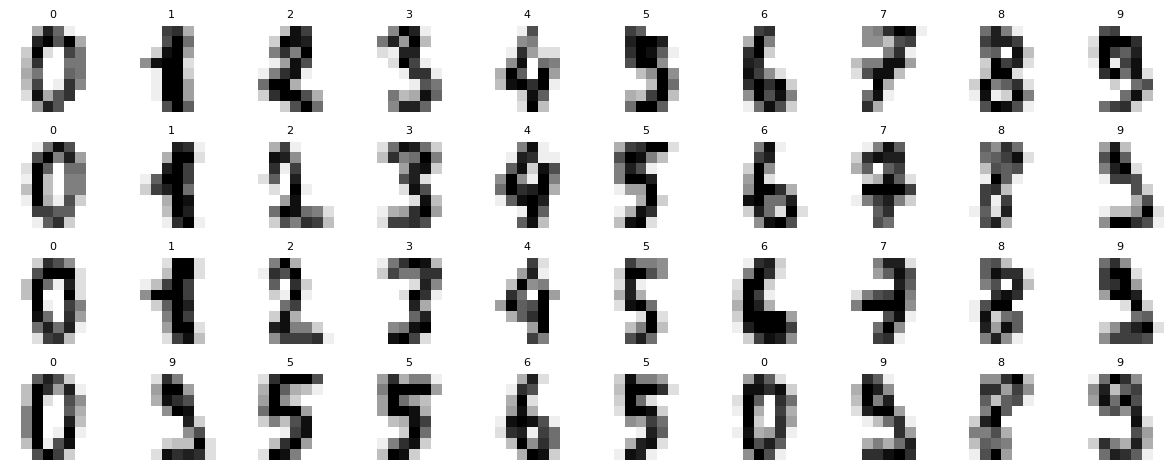

In [51]:

n_rows, n_cols = 4, 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.2, n_rows*1.2))
idx = 0
for r in range(n_rows):
    for c in range(n_cols):
        axes[r, c].imshow(images[idx], cmap='gray_r', interpolation='nearest')
        axes[r, c].set_title(str(y[idx]), fontsize=8)
        axes[r, c].axis('off')
        idx += 1
plt.tight_layout()
plt.show()



## 4. Scale features and (optionally) reduce dimensionality

K-Means benefits from feature scaling. We'll standardize features and create a 2D PCA projection for visualization.


In [54]:

scaler = StandardScaler()
with with_thread_limit(8):
    X_scaled = scaler.fit_transform(X)

pca2 = PCA(n_components=2, random_state=42)
with with_thread_limit(8):
    X_pca2 = pca2.fit_transform(X_scaled)

X_scaled.shape, X_pca2.shape


((1797, 64), (1797, 2))

## 5. Fit K-Means with k=10 (digits 0–9)

In [57]:

k = 10  # natural guess for digits 0..9
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
with with_thread_limit(8):
    kmeans.fit(X_scaled)

labels = kmeans.labels_      # predicted cluster index for each sample
inertia = kmeans.inertia_    # sum of squared distances to cluster centers
inertia, np.unique(labels), len(labels)


(69486.5144741779, array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), 1797)


## 6. Evaluate clustering

- **Silhouette score** (unsupervised)
- **ARI**, **NMI**, **Homogeneity/Completeness/V-measure** (label-aware; for diagnostics only)


In [60]:

sil = silhouette_score(X_scaled, labels, metric='euclidean')
ari = adjusted_rand_score(y, labels)
nmi = normalized_mutual_info_score(y, labels)
hom = homogeneity_score(y, labels)
com = completeness_score(y, labels)
vms = v_measure_score(y, labels)

print("Silhouette (unsupervised):", round(sil, 4))
print("ARI:", round(ari, 4))
print("NMI:", round(nmi, 4))
print("Homogeneity:", round(hom, 4))
print("Completeness:", round(com, 4))
print("V-measure:", round(vms, 4))


Silhouette (unsupervised): 0.1423
ARI: 0.478
NMI: 0.6319
Homogeneity: 0.6092
Completeness: 0.6564
V-measure: 0.6319


## 7. Visualize clusters in 2D PCA space

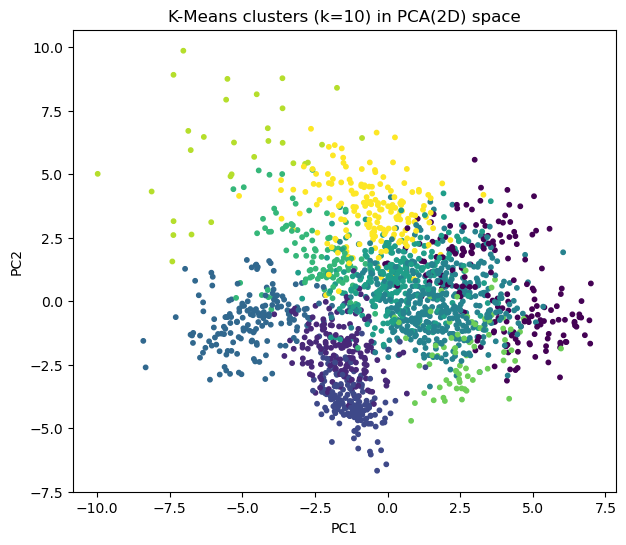

In [63]:

plt.figure(figsize=(7, 6))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], s=10, c=labels)
plt.title("K-Means clusters (k=10) in PCA(2D) space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



## 8. Map clusters to digits (Hungarian matching) and Confusion Matrix

We match cluster IDs to the most likely true digits to interpret results.


In [66]:

C = contingency_matrix(y, labels)  # shape (10, k)
row_ind, col_ind = linear_sum_assignment(C.max() - C)

cluster_to_digit = {cluster: digit for digit, cluster in zip(row_ind, col_ind)}
print("Cluster to digit mapping:", cluster_to_digit)

y_pred_mapped = np.array([cluster_to_digit[c] for c in labels])

cm = confusion_matrix(y, y_pred_mapped, labels=np.arange(10))
cm


Cluster to digit mapping: {np.int64(1): np.int64(0), np.int64(6): np.int64(1), np.int64(7): np.int64(2), np.int64(4): np.int64(3), np.int64(3): np.int64(4), np.int64(0): np.int64(5), np.int64(2): np.int64(6), np.int64(9): np.int64(7), np.int64(5): np.int64(8), np.int64(8): np.int64(9)}


array([[177,   0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,  58,  27,   0,   0,   0,   1,   0,  96,   0],
       [  0,   4,  48,   8,   0,  88,   0,   1,  28,   0],
       [  0,   0,   1, 157,   0,  10,   0,   7,   8,   0],
       [  0,   7,   0,   0, 158,   1,   0,   4,   2,   9],
       [  0,   3,   0,  77,   2,  69,   4,   5,  22,   0],
       [  1,   1,   0,   0,   0,   0, 174,   0,   5,   0],
       [  0,   3,   0,   0,   0,   8,   0, 150,   0,  18],
       [  0,  13,   0,  46,   0,  11,   2,   2, 100,   0],
       [  0,  19,   0, 146,   0,   1,   0,   8,   3,   3]])

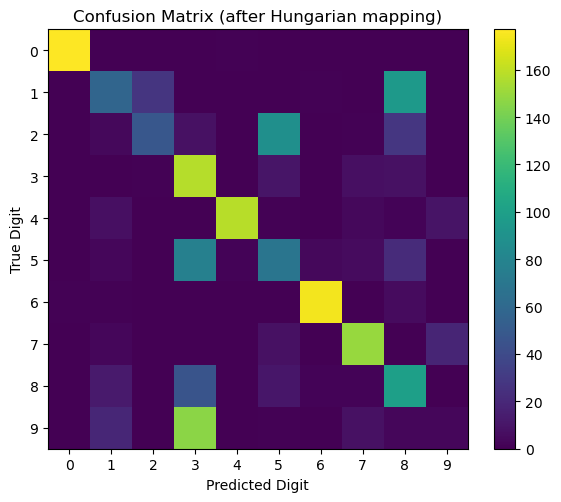

In [68]:

plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (after Hungarian mapping)")
plt.xlabel("Predicted Digit")
plt.ylabel("True Digit")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.colorbar()
plt.tight_layout()
plt.show()



## 9. Visualize cluster centers as prototype digits


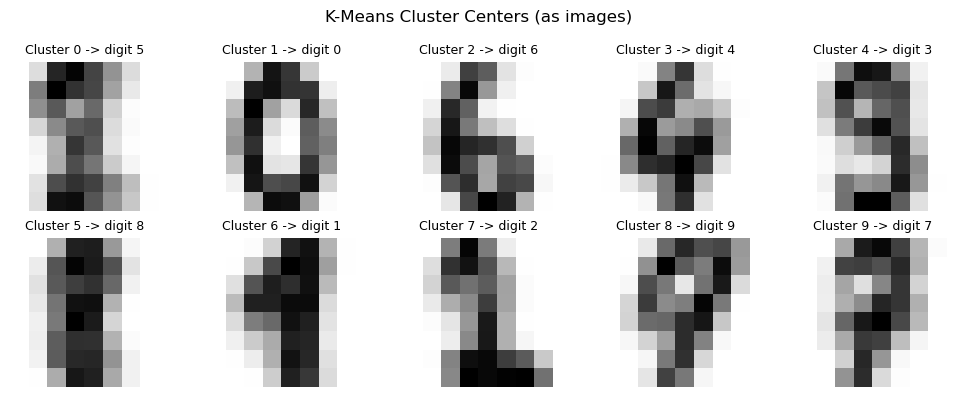

In [71]:

centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()
for i in range(k):
    axes[i].imshow(centers_original[i].reshape(8, 8), cmap='gray_r', interpolation='nearest')
    title = f"Cluster {i} -> digit {cluster_to_digit.get(i, '?')}"
    axes[i].set_title(title, fontsize=9)
    axes[i].axis('off')

plt.suptitle("K-Means Cluster Centers (as images)")
plt.tight_layout()
plt.show()



## 10. Choosing the number of clusters `k` — Elbow method

We sweep `k` from 2 to 21, plot inertia, and compute a simple curvature-based heuristic to **auto-suggest** an elbow.


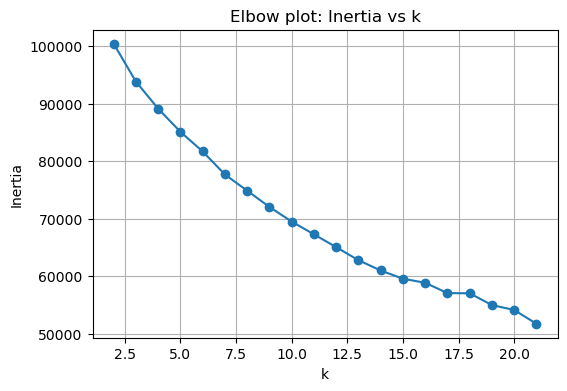

[100423.84303432592,
 93836.3853700733,
 89120.98873253606,
 85096.05466801408,
 81678.46669890734,
 77671.33891737863,
 74854.159171509,
 72025.61494425513,
 69486.5144741779,
 67261.84746124058,
 65031.72372831542,
 62763.1807536163,
 60975.010629272714,
 59534.49893709315,
 58835.14899080906,
 57038.158264310696,
 57000.78600491305,
 54955.465408695396,
 54099.955401195555,
 51708.670438417925]

In [74]:

ks = list(range(2, 22))
inertias = []

for kk in ks:
    km = KMeans(n_clusters=kk, n_init=20, random_state=42)
    with with_thread_limit(8):
        km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow plot: Inertia vs k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

inertias


In [77]:

# Auto-suggest k via discrete curvature (second finite difference)
import numpy as np
in_arr = np.array(inertias, dtype=float)
# Second difference for interior points
second_diff = in_arr[:-2] - 2*in_arr[1:-1] + in_arr[2:]
i_star = int(np.argmax(second_diff))  # index within ks[1:-1]
k_suggest = ks[1:-1][i_star]
print("Auto-suggested k (curvature heuristic):", k_suggest)


Auto-suggested k (curvature heuristic): 3



## 11. Silhouette scores for the same range of `k`

Higher is better (range: -1..1). Compare the silhouette peak with the elbow suggestion.


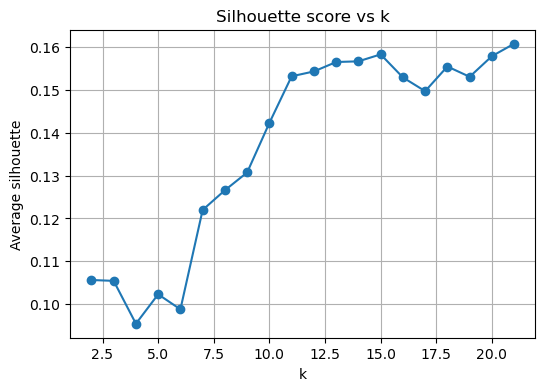

[(2, np.float64(0.1056)),
 (3, np.float64(0.1054)),
 (4, np.float64(0.0954)),
 (5, np.float64(0.1023)),
 (6, np.float64(0.0988)),
 (7, np.float64(0.122)),
 (8, np.float64(0.1266)),
 (9, np.float64(0.1307)),
 (10, np.float64(0.1423)),
 (11, np.float64(0.1532)),
 (12, np.float64(0.1543)),
 (13, np.float64(0.1565)),
 (14, np.float64(0.1567)),
 (15, np.float64(0.1583)),
 (16, np.float64(0.1529)),
 (17, np.float64(0.1497)),
 (18, np.float64(0.1555)),
 (19, np.float64(0.1531)),
 (20, np.float64(0.1579)),
 (21, np.float64(0.1608))]

In [80]:

sil_scores = []
for kk in ks:
    km = KMeans(n_clusters=kk, n_init=20, random_state=42)
    with with_thread_limit(8):
        labels_k = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels_k, metric='euclidean')
    sil_scores.append(sil)

plt.figure(figsize=(6, 4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette score vs k")
plt.xlabel("k")
plt.ylabel("Average silhouette")
plt.grid(True)
plt.show()

list(zip(ks, np.round(sil_scores, 4)))



## 12. Key takeaways

- Set `OMP_NUM_THREADS` (and friends) early to avoid noisy timings and oversubscription.
- **Scaling** is essential for K-Means.
- Use both **elbow** and **silhouette**; don't rely on one method alone.
- Hungarian matching helps interpret clusters against known labels.
- Cluster centers are helpful "prototype" images.
